# Introduction

This lab demonstrates the use of **Pipeline** and **GridSearchCV** in scikit-learn to optimize over different classes of estimators in a single CV run. We will be using a support vector classifier to predict hand-written digits from the popular MNIST dataset.

# Import necessary libraries and load data

We will begin by importing the necessary libraries and load the digits dataset from scikit-learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

X, y = load_digits(return_X_y=True)

# Create a pipeline and define parameter grid

We will create a pipeline that does dimensionality reduction followed by prediction with a support vector classifier. We will use unsupervised PCA and NMF dimensionality reductions, along with univariate feature selection during the grid search

In [2]:
pipe = Pipeline(
    [
        ('scaling', MinMaxScaler()),
        # the reduce_dim_stage is populated by the param_grid
        ('reduce_dim', 'passthrough'),
        ('classify', LinearSVC(dual=False, max_iter=1000)),
    ]
)

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF(max_iter=1_000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
    },
    {
        'reduce_dim':[SelectKBest(mutual_info_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(mutual_info_classif)']

# Create a GridSearchCV object and fit data

We will create a **GridSearchCV** object using the pipeline and parameter grid we defined in the previous step. We will then fit the data to the object.

In [3]:
grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', LinearSVC(dual=False))]),
             n_jobs=1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7),
                                         NMF(max_iter=1000)],
                          'reduce_dim__n_components': [2, 4, 8]},
                         {'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [SelectKBest(score_func=<function mutual_info_classif at 0x127844360>)],
                          'reduce_dim__k': [2, 4, 8]}])

# Plot results

We will plot the results of the **GridSearchCV** using a bar chart. This will allow us to compare the accuracy of different feature reduction techniques.

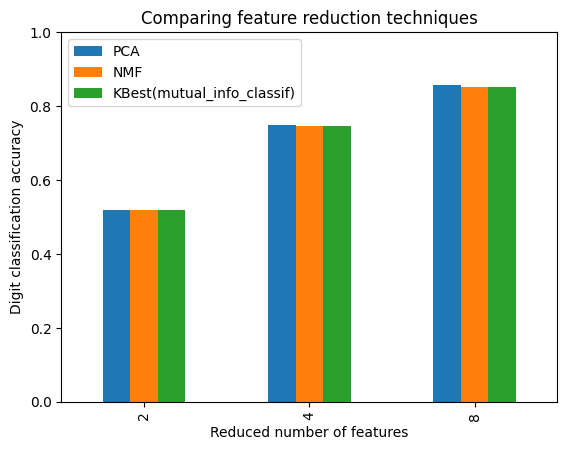

In [4]:
import pandas as pd

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
# create a dataframe to ease plotting
mean_scores = pd.DataFrame(mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()

# Caching transformers within a Pipeline

We will now demonstrate how to store the state of a specific transformer, since it could be used again. Using a pipeline in **GridSearchCV** triggers such situations. Therefore, we use the argument **memory** to enable caching.

In [5]:
from joblib import Memory
from shutil import rmtree

# Create a temporary folder to store the transformers of the pipeline
location = 'cachedir'
memory = Memory(location=location, verbose=10)
cached_pipe = Pipeline(
    [('reduce_dim', PCA()), ('classify', LinearSVC(dual=False, max_iter=10000))],
    memory=memory,
)

# This time, a cached pipeline will be used withing the grid search

# Delete the temporary cache before exiting
memory.clear(warn=False)
rmtree(location)

# Summary

In this lab, we used **Pipeline** and **GridSearchCV** in scikit-learn to optimize over different classes of estimators in a single CV run. We also demonstrated how to store the state of a specific transformer using the **memory** argument to enable caching. This can be particularly useful when fitting a transformer is costly.